In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import merged data without the index column
df = pd.read_csv('merged_df.csv', index_col=None)

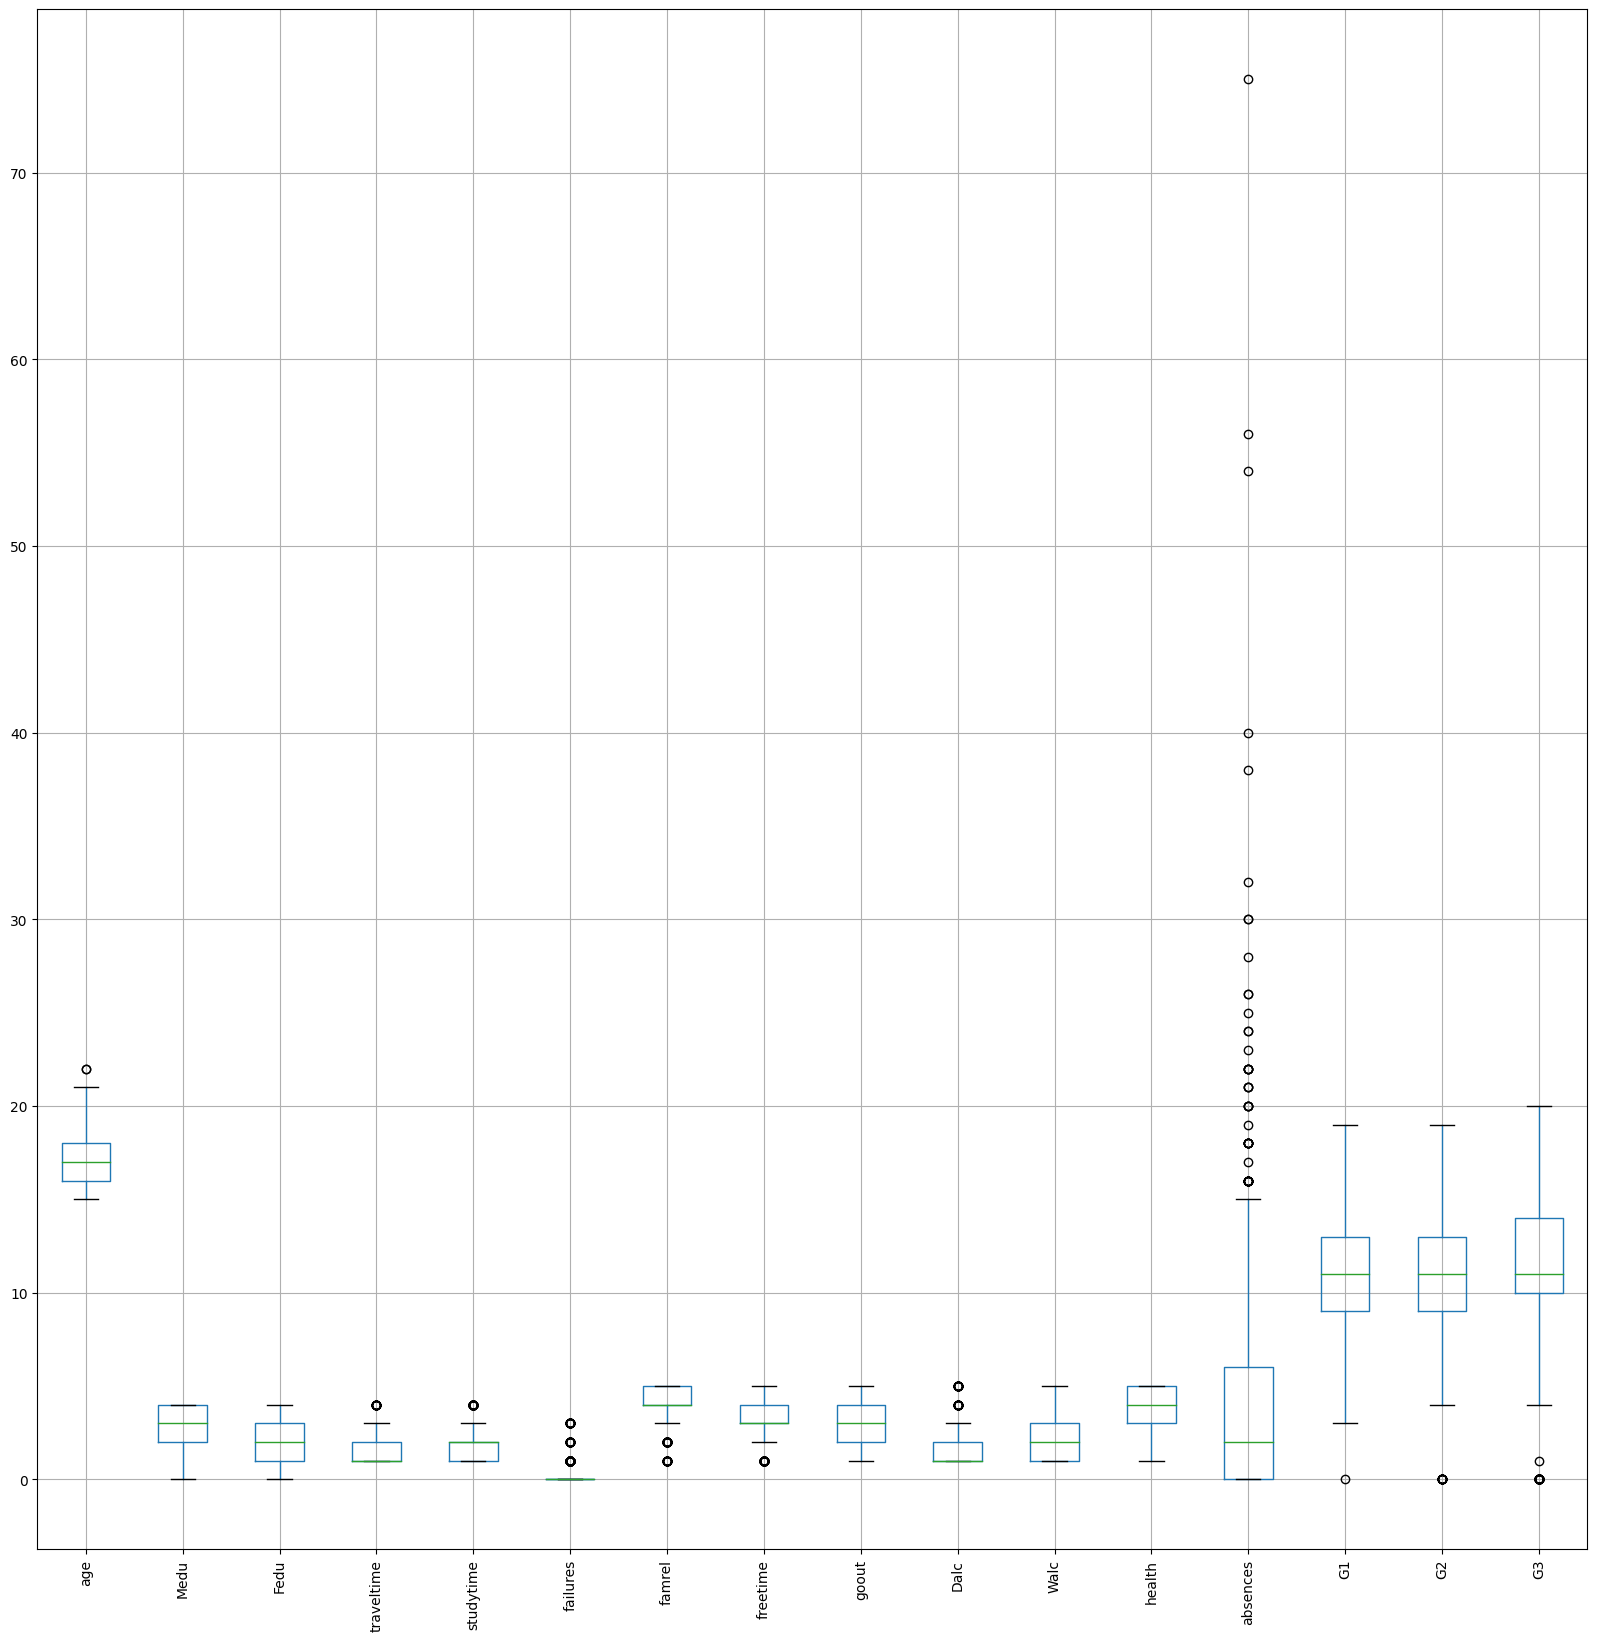

In [3]:
# analyze the data to find outliers 
# plot box plots for each column
df.boxplot(figsize=(20,20), rot=90)
plt.show()

In [4]:
# looking column absences outlier statiscally
df['absences'].describe()
# remove outliers
df = df[df['absences'] < 20]


## Transform the data
*   Create two datasets one for categorical and another for numerical columns.
*   Usage of the method get_dummies() to convert categorical columns into numerical columns.
*   Concatenation of the two datasets before standardization.
*   Usage of the method StandardScaler() to scale making all the values been between 0 and 1.
*   Usage of method StandardScaler() to scale the numerical columns.

In [5]:
# Making 2 dataframes for categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object', 'category'])
continuous_cols = df[['age', 'absences']]

# remove the targets columns that wont be used for our clustering
categorical_cols = categorical_cols.drop(['absences_range', 'academicGrade'], axis=1)

In [6]:
# Transform categorical columns with the method get_dummies,
# and left out target 'finalresult', 'G1'... and continuous columns also unnecessary columns.
categorical_cols = pd.get_dummies(df[df.columns[~df.columns.isin(['age', 
                                                                  'absences', 'absences_range', 'academicGrade', 'finalResult', 'G1', 'G2', 'G3'])]])

In [7]:
# concatenate categorical and continuous columns
num_scaled = pd.concat([categorical_cols, continuous_cols], axis=1)
# normalize the data
scaler = MinMaxScaler()
df_final = pd.DataFrame(scaler.fit_transform(num_scaled), columns=num_scaled.columns)

## Clustering

For n_clusters = 2 The average silhouette_score is : 0.0699308079932
For n_clusters = 3 The average silhouette_score is : 0.0639826274831274
For n_clusters = 4 The average silhouette_score is : 0.05961417315315574
For n_clusters = 5 The average silhouette_score is : 0.05370577832248877
For n_clusters = 6 The average silhouette_score is : 0.05675219238278901


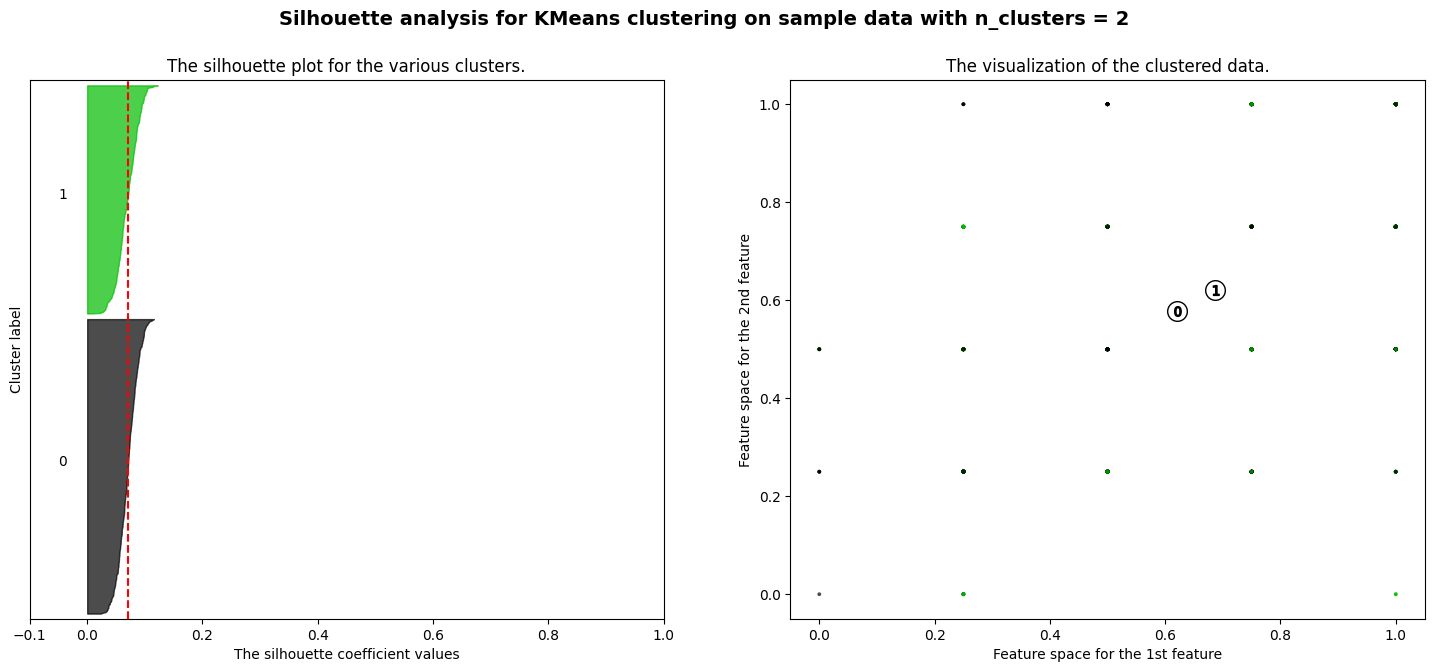

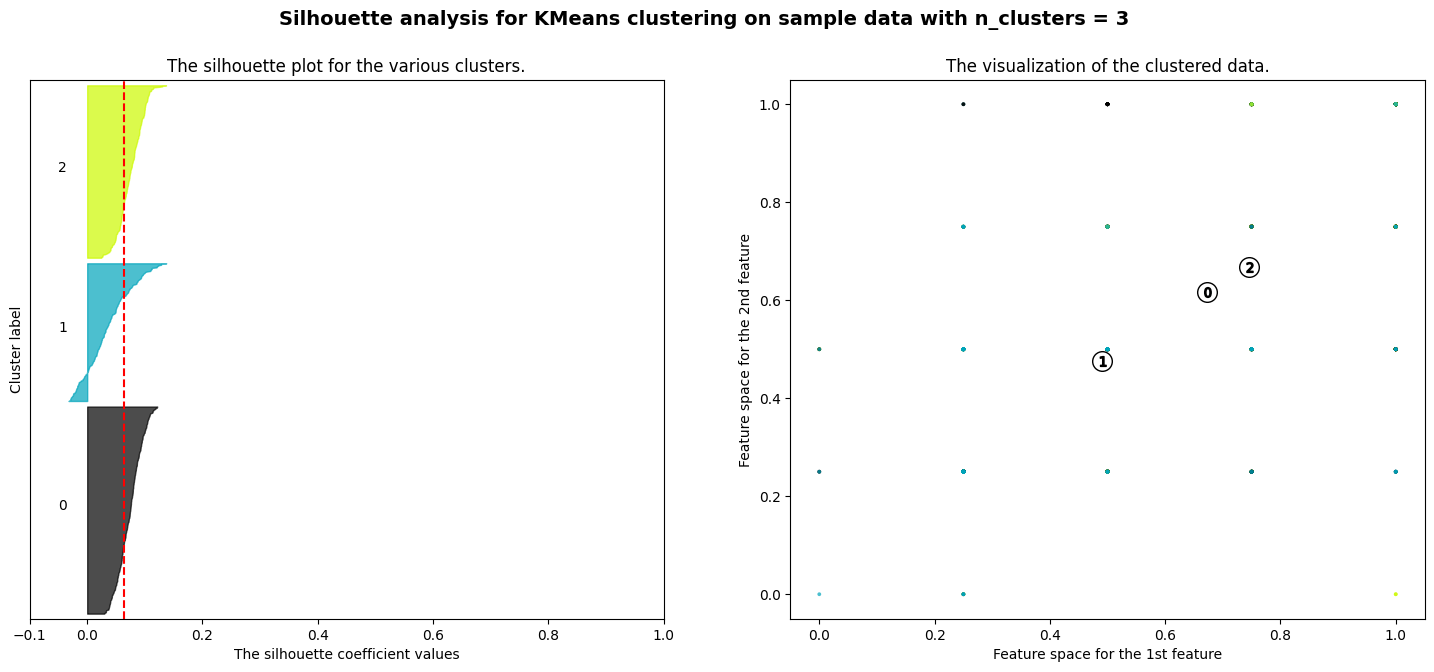

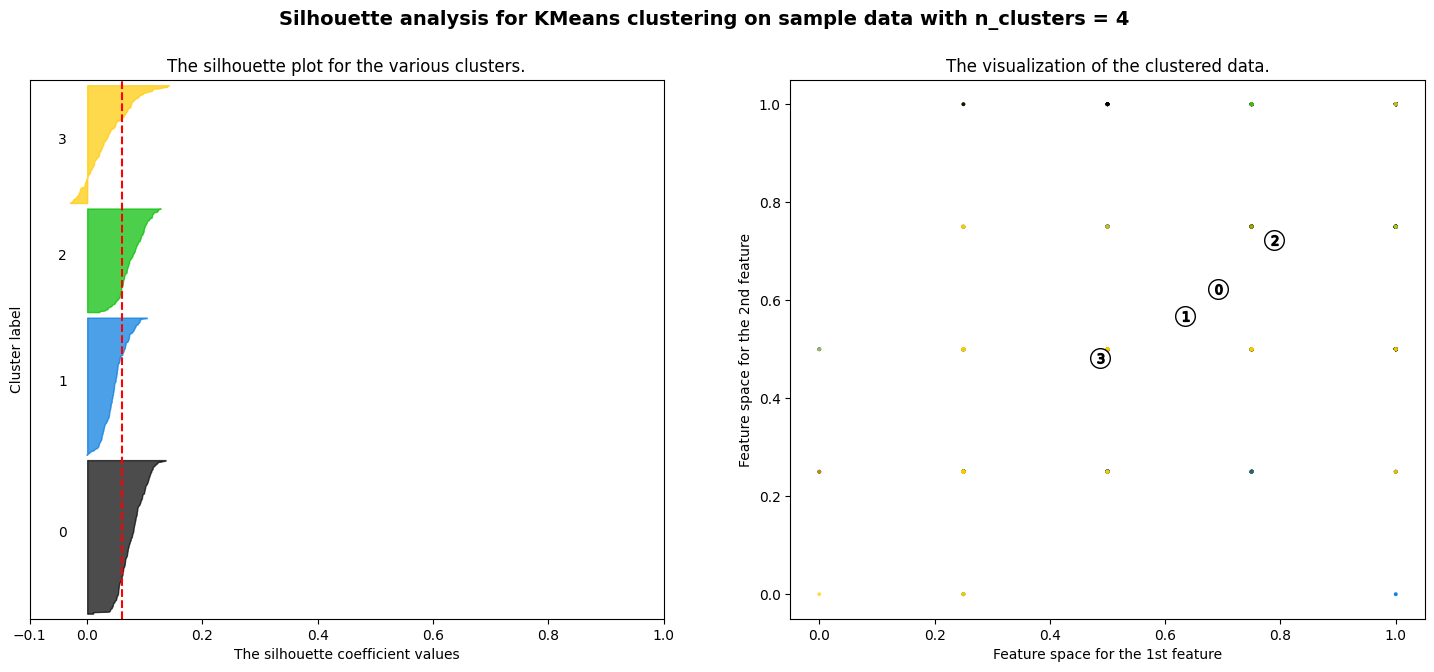

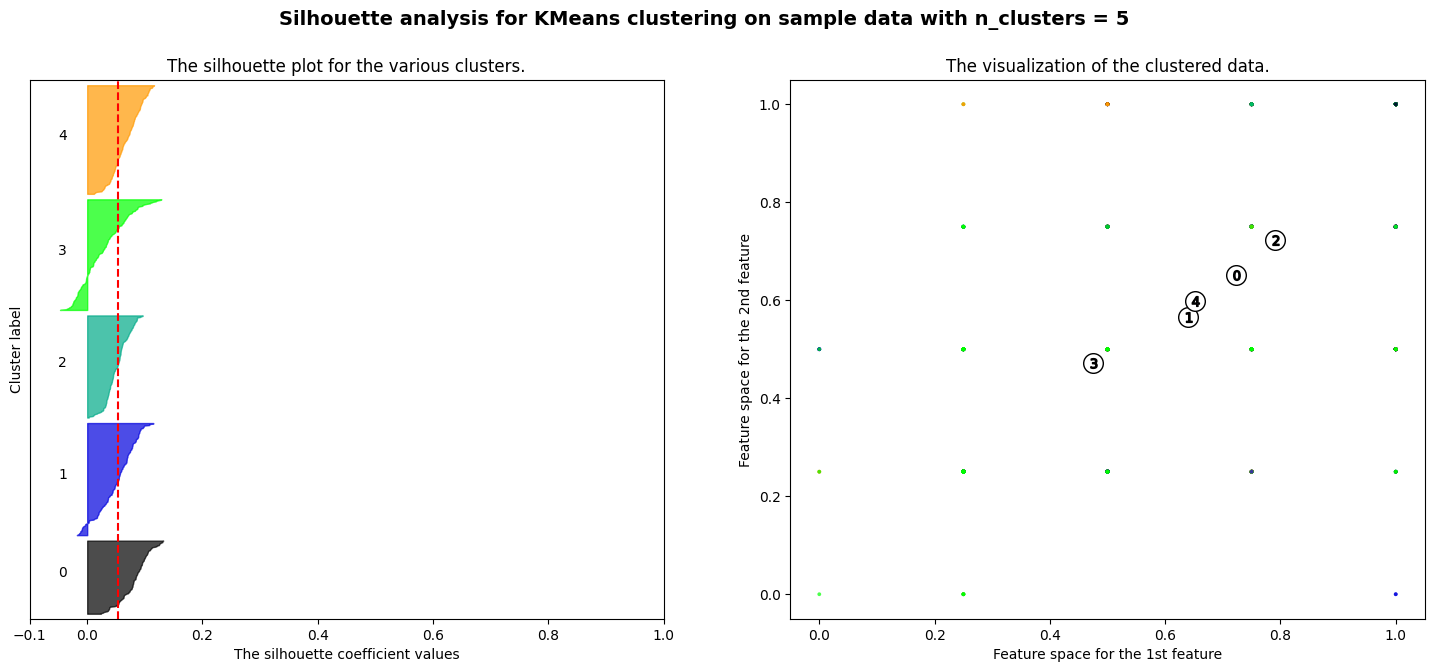

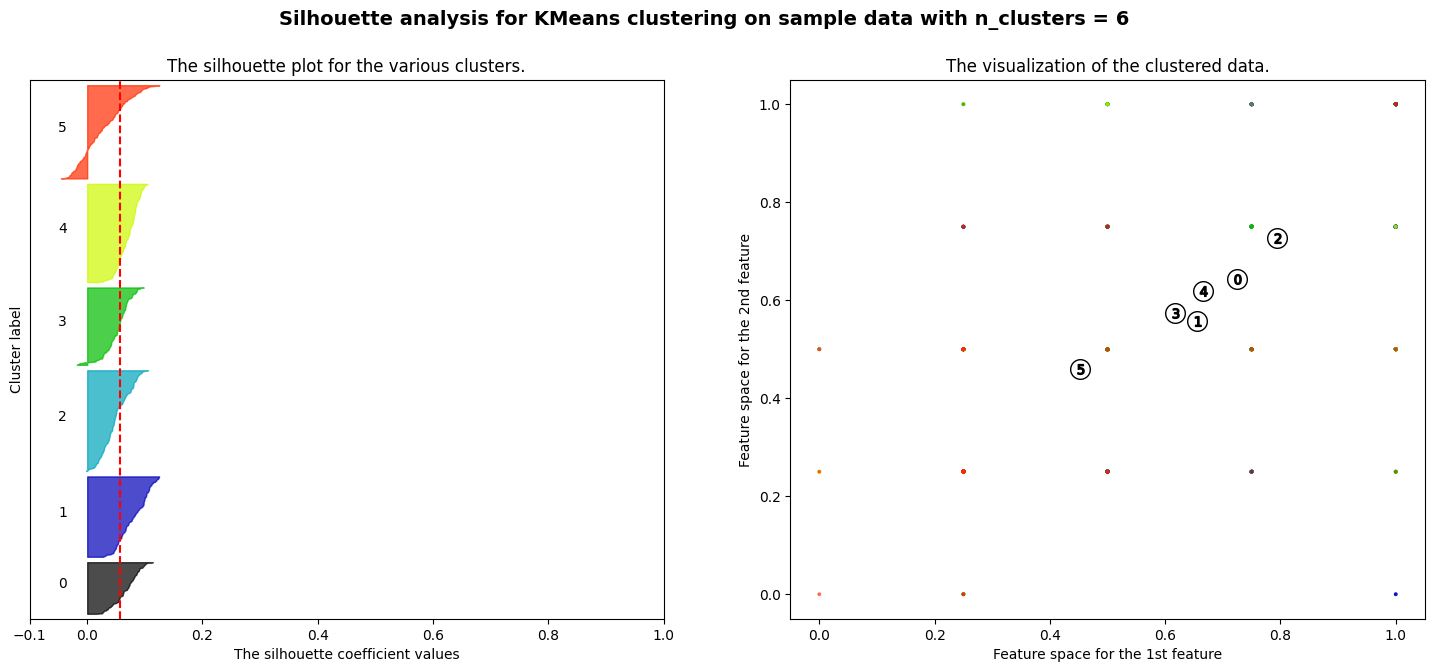

In [8]:
range_n_clusters = [2, 3, 4, 5, 6]
"""Loop to find the best number of clusters, using technique calls 'silhouette'.
The silhouette coefficient is a measure of cluster cohesion and separation.
It quantifies how well a data point fits into its assigned cluster based on two factors:
    - How close the data point is to other points in the cluster
    - How far away the data point is from points in other clusters
Silhouette coefficients near +1 indicate that the sample is far away from the neighboring clusters.
A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters
and negative values indicate that those samples might have been assigned to the wrong cluster.

"""

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_final) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(df_final)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_final, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_final, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        df_final.iloc[:, 0], df_final.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

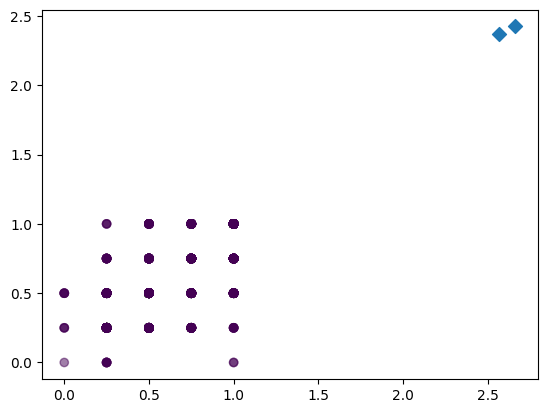

In [9]:
# Import KMeans
from sklearn.cluster import KMeans
# Create a KMeans instance with 3 clusters: model
model = KMeans(n_clusters=2)
# Fit model to points
model.fit(num_scaled)

new_points = df_final.iloc[:,0:].values
# Determine the cluster labels of new_points: labels
labels = model.predict(new_points)
# Assign the columns of new_points: xs and ys
xs = new_points[:,0]
ys = new_points[:,1]
# Make a scatter plot of xs and ys, using labels to define the colors
plt.scatter(xs,ys,c=labels,alpha=0.5)
# Assign the cluster centers: centroids
centroids = model.cluster_centers_
# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]
# Make a scatter plot of centroids_x and centroids_y
plt.scatter(centroids_x,centroids_y,marker='D',s=50)
plt.show()

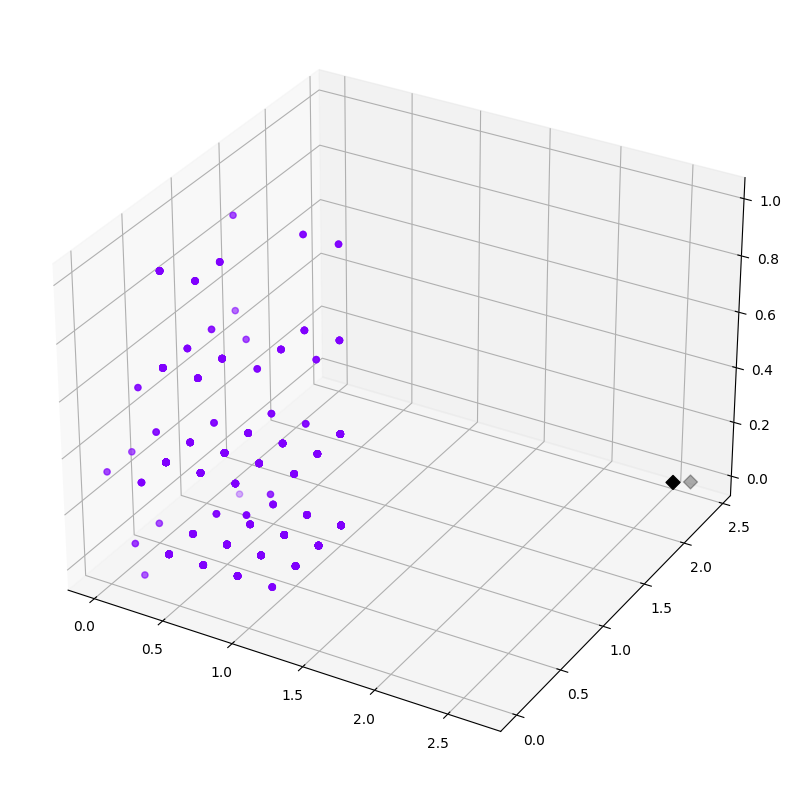

In [10]:
# plot in higher dimension the clusters and the centroids

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_final.iloc[:,0], df_final.iloc[:,1], df_final.iloc[:,2], c=labels, cmap='rainbow')
# add centroids
ax.scatter(centroids_x,centroids_y, marker='D', s=50, c='black')
plt.show()


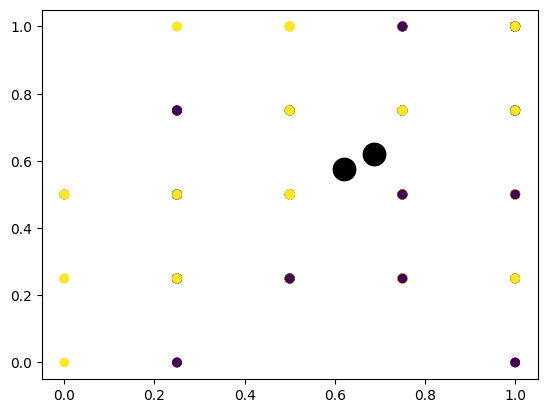

In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Apply KMeans clustering with 4 clusters
kmeans = KMeans(n_clusters=2)
kmeans.fit(df_final)

# Get the cluster labels and cluster centers
labels = kmeans.predict(df_final)
centers = kmeans.cluster_centers_

# Plot the data points with colors representing their clusters
plt.scatter(df_final.iloc[:, 0], df_final.iloc[:, 1], c=labels, cmap='viridis')

# Plot the cluster centers as black circles
plt.scatter(centers[:, 0], centers[:, 1], marker='o', s=200, linewidths=3, color='black', zorder=5)
plt.show()


In [12]:
# use kprotoypes to cluster categorical and numerical data
from kmodes.kprototypes import KPrototypes
# set the number of clusters
kproto = KPrototypes(n_clusters=2, init='Cao', verbose=2)
# fit the data
clusters = kproto.fit_predict(df_final, categorical_cols=list(categorical_cols.columns))



In [13]:
# Instatiate the KMeans algorithm with 2 clusters
n_clusters = 2

clusterer = KMeans(n_clusters=n_clusters, init='k-means++', random_state=10)
cluster_labels = clusterer.fit(df_final)

# Predicting the Clusters
pd.options.display.max_columns = 10
predictions = cluster_labels.labels_
df_final['Clusters'] = predictions
df_final

,Medu,Fedu,traveltime,studytime,failures,...,romantic_no,romantic_yes,age,absences,Clusters
0,1.00,1.00,0.333333,0.333333,0.000000,...,1.0,0.0,0.428571,0.315789,0
1,0.25,0.25,0.000000,0.333333,0.000000,...,1.0,0.0,0.285714,0.210526,0
2,0.25,0.25,0.000000,0.333333,1.000000,...,1.0,0.0,0.000000,0.526316,0
3,1.00,0.50,0.000000,0.666667,0.000000,...,0.0,1.0,0.000000,0.105263,0
4,0.75,0.75,0.000000,0.333333,0.000000,...,1.0,0.0,0.142857,0.210526,0
...,...,...,...,...,...,...,...,...,...,...,...
1012,0.50,0.75,0.000000,0.666667,0.333333,...,1.0,0.0,0.571429,0.210526,0
1013,0.75,0.25,0.000000,0.333333,0.000000,...,1.0,0.0,0.428571,0.210526,0
1014,0.25,0.25,0.333333,0.333333,0.000000,...,1.0,0.0,0.428571,0.315789,0
1015,0.75,0.25,0.333333,0.000000,0.000000,...,1.0,0.0,0.285714,0.315789,1


In [14]:
# Add label column
df_final['finalResult'] = df['finalResult']
# tranform only label column from fail to pass in 0 and 1
df_final['finalResult'] = df_final['finalResult'].apply(lambda x: 0 if x == 'fail' else 1)

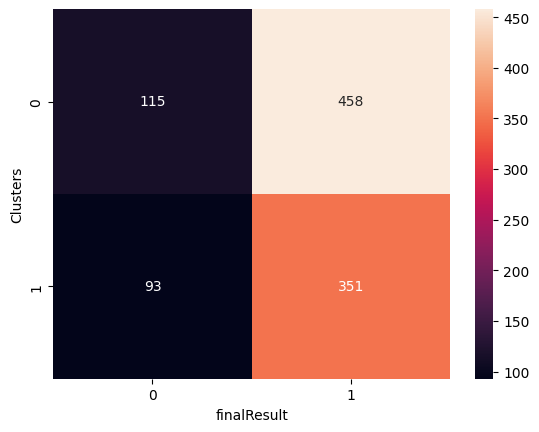

              precision    recall  f1-score   support

           0       0.20      0.55      0.29       208
           1       0.79      0.43      0.56       809

    accuracy                           0.46      1017
   macro avg       0.50      0.49      0.43      1017
weighted avg       0.67      0.46      0.51      1017



In [15]:
# Analyse Clusters result and finalResult with crosstab 
pd.crosstab(df_final['Clusters'], df_final['finalResult'], margins=True)
# plot confusion matrix
sns.heatmap(pd.crosstab(df_final['Clusters'], df_final['finalResult']), annot=True, fmt='d')
plt.show()

# Get the precision, recall, f1-score and support
from sklearn.metrics import classification_report
print(classification_report(df_final['finalResult'], df_final['Clusters']))


AUC: 0.493


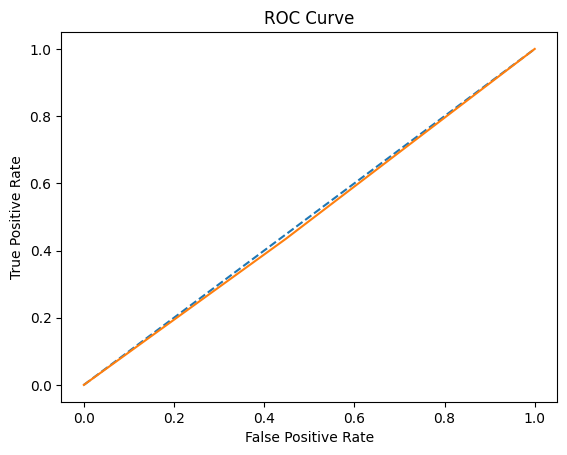

In [16]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# calculate roc curve
fpr, tpr, thresholds = roc_curve(df_final['finalResult'], df_final['Clusters'])
# calculate AUC
auc = roc_auc_score(df_final['finalResult'], df_final['Clusters'])
print('AUC: %.3f' % auc)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
# show the plot
plt.show()


## Testing other classification algorithms
* SVM
* Linear discriminant analysis
* Logistic regression classifier
* Decision tree classifier
* Voting classifier

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from json_config_expander import expand_configs
from xgboost import XGBClassifier

In [18]:
# drop clusters column and finalResult column
df_final = df_final.drop(['Clusters'], axis=1)

# define X and y
X = df_final[df_final.columns[~df_final.columns.isin(['finalResult'])]]
y = df_final['finalResult']

In [19]:
# Check if the labels are balanced
y.value_counts()

finalResult
1    809
0    208
Name: count, dtype: int64

In [20]:
# Using SMOTE to balance the labels
from imblearn.over_sampling import SMOTE

# SMOTE works by selecting examples that are close in the feature space, drawing 
# a line between the examples in the feature space and drawing a new sample at a point along that line.

# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

# Check if the labels are balanced
y.value_counts()

finalResult
0    809
1    809
Name: count, dtype: int64

### Training and testing the model

In [21]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#X_train, X_validation, y_train, y_validation = train_test_split(X_train_complete, y_train_complete, test_size=0.2)

SVC classifier

In [22]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def training_pipeline(clf , X_train, y_train, X_test, y_test, param_grid):
    # Define hyperparameter grid
    # Perform grid search for best parameters
    grid = GridSearchCV(clf, param_grid, refit=True)
    grid.fit(X_train, y_train)
    # Print best parameter after tuning
    print(f"Best parameters: {grid.best_params_}")
    # Print classification report and confusion matrix for training set
    X_train_result = grid.predict(X_train)
    print(f"Classification report for training set:\n{classification_report(y_train, X_train_result)}")
    cm_train = confusion_matrix(y_train, X_train_result)
    sns.heatmap(cm_train, annot=True)
    plt.show()
    # Evaluate model on testing set and print results
    grid_predictions = grid.predict(X_test)
    print(f"Classification report for testing set:\n{classification_report(y_test, grid_predictions)}")
    cm_test = confusion_matrix(y_test, grid_predictions)
    sns.heatmap(cm_test, annot=True)
    plt.show()


Best parameters: {'C': 100, 'gamma': 1}
Classification report for training set:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       646
           1       1.00      0.99      0.99       648

    accuracy                           0.99      1294
   macro avg       0.99      0.99      0.99      1294
weighted avg       0.99      0.99      0.99      1294



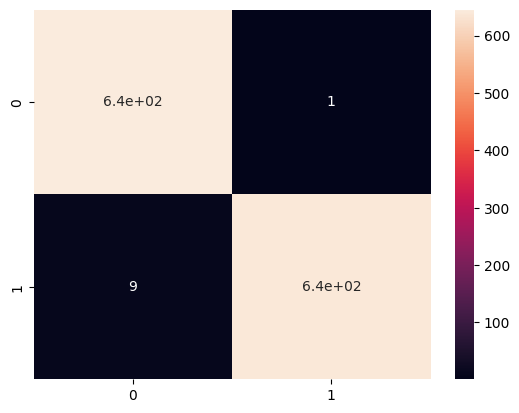

Classification report for testing set:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       163
           1       0.86      0.91      0.89       161

    accuracy                           0.89       324
   macro avg       0.89      0.89      0.89       324
weighted avg       0.89      0.89      0.89       324



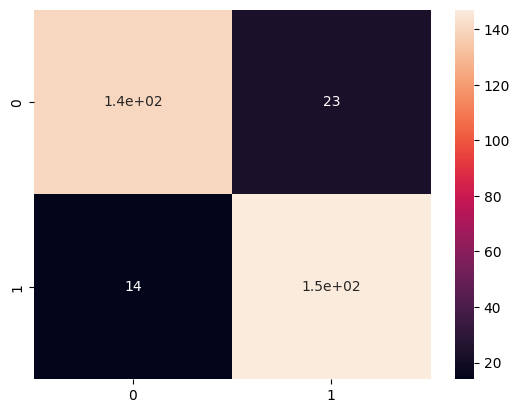

In [23]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
clf = SVC()
training_pipeline(clf, X_train, y_train, X_test, y_test, param_grid= param_grid)

Linear discriminant analysis

Best parameters: {'solver': 'svd'}
Classification report for training set:
              precision    recall  f1-score   support

           0       0.65      0.66      0.65       646
           1       0.65      0.65      0.65       648

    accuracy                           0.65      1294
   macro avg       0.65      0.65      0.65      1294
weighted avg       0.65      0.65      0.65      1294



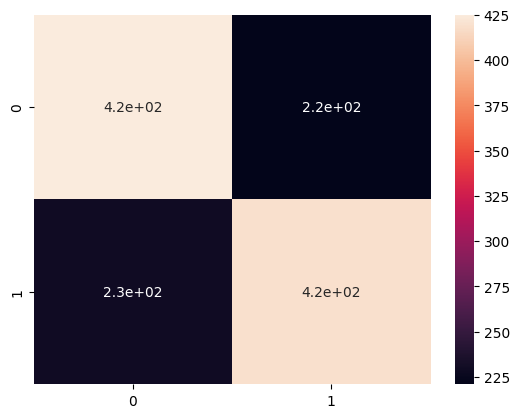

Classification report for testing set:
              precision    recall  f1-score   support

           0       0.62      0.55      0.58       163
           1       0.59      0.66      0.63       161

    accuracy                           0.60       324
   macro avg       0.61      0.61      0.60       324
weighted avg       0.61      0.60      0.60       324



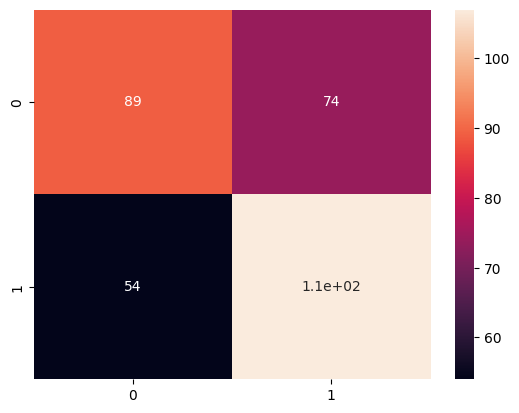

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
param_grid = {'solver': ['svd', 'lsqr', 'eigen']}
clf = LinearDiscriminantAnalysis()

training_pipeline(clf, X_train, y_train, X_test, y_test, param_grid= param_grid)

Logistic regression classifier

Best parameters: {'C': 0.1, 'solver': 'newton-cg'}
Classification report for training set:
              precision    recall  f1-score   support

           0       0.66      0.67      0.66       646
           1       0.66      0.65      0.66       648

    accuracy                           0.66      1294
   macro avg       0.66      0.66      0.66      1294
weighted avg       0.66      0.66      0.66      1294



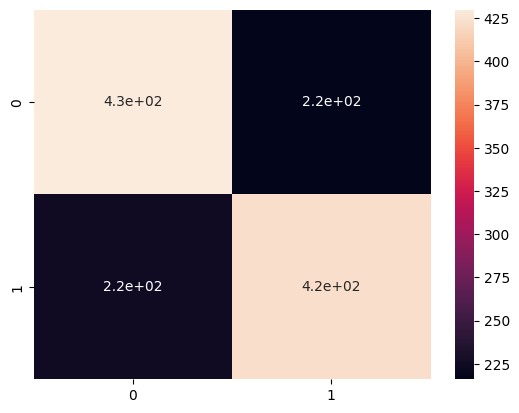

Classification report for testing set:
              precision    recall  f1-score   support

           0       0.62      0.60      0.61       163
           1       0.61      0.63      0.62       161

    accuracy                           0.61       324
   macro avg       0.61      0.61      0.61       324
weighted avg       0.61      0.61      0.61       324



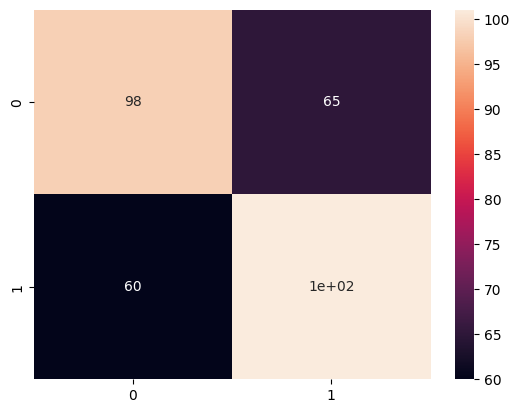

In [25]:
# Testing logistic regression classifier
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.1, 1, 10, 100, 1000], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
clf = LogisticRegression()

training_pipeline(clf, X_train, y_train, X_test, y_test, param_grid= param_grid)

Decision tree classifier

Best parameters: {'criterion': 'entropy', 'max_depth': 10}
Classification report for training set:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       646
           1       0.91      0.96      0.94       648

    accuracy                           0.93      1294
   macro avg       0.93      0.93      0.93      1294
weighted avg       0.93      0.93      0.93      1294



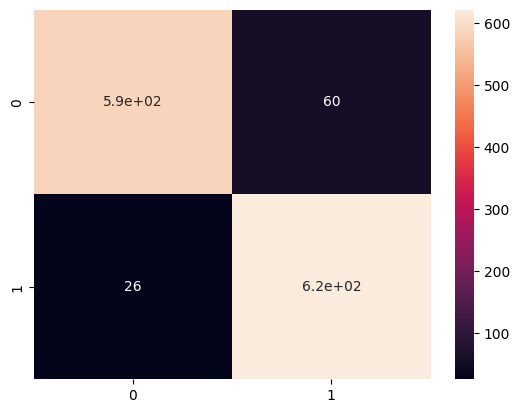

Classification report for testing set:
              precision    recall  f1-score   support

           0       0.79      0.70      0.74       163
           1       0.73      0.81      0.77       161

    accuracy                           0.76       324
   macro avg       0.76      0.76      0.76       324
weighted avg       0.76      0.76      0.76       324



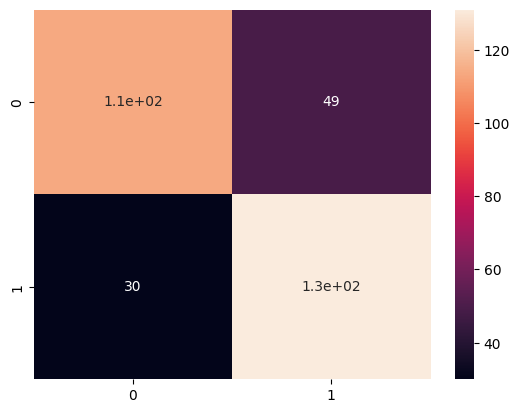

In [26]:
# Testing Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16]}

training_pipeline(clf, X_train, y_train, X_test, y_test, param_grid= param_grid)

 Voting classifier

In [27]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV

# Define classifiers to use in the VotingClassifier
clf1 = LogisticRegression()
clf2 = LinearDiscriminantAnalysis()
clf3 = DecisionTreeClassifier()
clf4 = SVC()

# Define the parameter grid for each classifier
param_grid1 = {'C': [0.1, 1, 10, 100, 1000], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
param_grid2 = {'solver': ['svd', 'lsqr', 'eigen']}
param_grid3 = {'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16]}
param_grid4 = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

# Perform grid search for each classifier
grid1 = GridSearchCV(clf1, param_grid1, refit=True)
grid1.fit(X_train, y_train)

grid2 = GridSearchCV(clf2, param_grid2, refit=True)
grid2.fit(X_train, y_train)

grid3 = GridSearchCV(clf3, param_grid3, refit=True)
grid3.fit(X_train, y_train)

grid4 = GridSearchCV(clf4, param_grid4, refit=True)
grid4.fit(X_train, y_train)
# Define the voting classifier using the best hyperparameters for each classifier
voting_clf = VotingClassifier(
    estimators=[('LogisticRegression', grid1.best_estimator_), ('LinearDiscriminant', grid2.best_estimator_), 
                ('DecisionTree', grid3.best_estimator_), ('SVC', grid4.best_estimator_)], voting='hard')

# Train the voting classifier on the training set
voting_clf.fit(X_train, y_train)

# plot f1-score for each classifier
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Predict the labels of the test set
y_pred = voting_clf.predict(X_test)
print("F1-score for voting classifier: %.3f" % f1_score(y_test, y_pred))

# Evaluate the voting classifier on the testing set
#print("Classification report for voting classifier:")
#print(classification_report(y_test, voting_clf.predict(X_test)))


F1-score for voting classifier: 0.701


In [28]:
print("Classification report for voting classifier:")
print(classification_report(y_test, voting_clf.predict(X_test)))

Classification report for voting classifier:
              precision    recall  f1-score   support

           0       0.70      0.83      0.76       163
           1       0.78      0.63      0.70       161

    accuracy                           0.73       324
   macro avg       0.74      0.73      0.73       324
weighted avg       0.74      0.73      0.73       324



### Classifier mappins

In [29]:
BASE_CONFIG = {"classifier*": [
   {
      "name": "random_forest",
      "parameters": {"max_depth*": [3, 5], "n_estimators*": [50, 100, 200]}
   },
   {
      "name": "logistic_regression",
      "parameters": {"max_iter*": [10, 100, 1000], "C*": [0.1, 0.5, 1]}
   },
   {
      "name": "xgboost",
      "parameters": {"max_depth*": [3, 4, 5], "n_estimators*": [50, 100, 200], "learning_rate*": [0.01, 0.05, 0.1]}
   }]
}


CLASSIFIER_MAPPINGS = {"random_forest": RandomForestClassifier, "xgboost": XGBClassifier, "logistic_regression": LogisticRegression}

def evaluate_model(config, X_train, X_test, y_train, y_test):
   classifier = CLASSIFIER_MAPPINGS[config["classifier"]["name"]](**config["classifier"]["parameters"])
   classifier.fit(X_train, y_train)
   test_scores = classifier.predict_proba(X_test)[:, 1]
   roc_auc = roc_auc_score(y_test, test_scores)
   classication_report = classification_report(y_test, classifier.predict(X_test))
   return {"config": config, "roc_auc": roc_auc, "classification_report": classication_report}


results = expand_configs(BASE_CONFIG,
   lambda config: evaluate_model(config, X_train, X_validation, y_train, y_validation))


best_result = max(results, key=lambda res: res["roc_auc"])
best_config = best_result["config"]

result_on_test = evaluate_model(best_config, X_train_complete, X_test, y_train_complete, y_test)
print(result_on_test["classification_report"])

NameError: name 'X_validation' is not defined